In [6]:
# Import packages

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray
import math
import glob
import os
import fiona
import io
import pathlib
import requests

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from rasterio.crs import CRS
from rasterio.features import rasterize

import shapely
from shapely.geometry import Polygon
from shapely.geometry import mapping
from shapely.geometry import box

from tqdm import tqdm
from affine import Affine
from zipfile import ZipFile

import logging
logging.basicConfig(level=logging.INFO)

import atlite
from atlite.gis import ExclusionContainer, shape_availability

import warnings
import fnmatch
# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [7]:
aggregated_regions = [
    'AT', 'BE', 'BG', 'CH', 'CZ', 'DE',
    'DK', 'EE', 'ES', 'FI', 'FR', 'UK',
    'GR', 'HR', 'HU', 'IE', 'IT', 'LT',
    'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 
    'RO', 'SE', 'SI', 'SK',
]

In [8]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query('NUTS_ID == @aggregated_regions')
    .set_index(['NUTS_ID'])
    .loc[:,['geometry']]
)

In [9]:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)

In [10]:
def get_bounding():
    
    rectx1 = -12
    rectx2 = 44
    recty1 = 33
    recty2 = 72
    
    polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
    )
    
    polygon=shapely.segmentize(polygon, max_segment_length=0.5)
    
    b=gpd.GeoDataFrame(geometry=[polygon],crs="EPSG:4326")
 
    return b.to_crs("EPSG:3035")

In [11]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} \n Eligible area (green) {eligible_share * 100:2.2f}%')

In [18]:
def process_geopackages(base_dir, output_tiff, resolution=100):
    '''
    Fetch the euhydro geopackage files, rasterize and buffer around them. 

    Args:
        base_dir: Directory of all subfolders
        output_tiff: Name of output file
        buffer_poly: Buffer distance for polygons
        buffer_line: Buffer distance for linestrings
        resolution: Resolution of output dataset (default = 100m)
    '''
    # Define the pattern to match the main GeoPackage files
    main_file_pattern = 'euhydro_*_v013.gpkg'

    # List all matching GeoPackage files
    gpkg_files = [os.path.join(root, file)
                  for root, _, files in os.walk(base_dir)
                  for file in files if fnmatch.fnmatch(file, main_file_pattern)]

    # Layers to include
    layers_to_include = ['InlandWater','River_Net_l','Canals_l']  
    # For CRS in meters
    minx, maxx, miny, maxy = get_bounding().bounds.minx[0], get_bounding().bounds.maxx[0], get_bounding().bounds.miny[0], get_bounding().bounds.maxy[0]

    # Prepare rasterization parameters
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = from_bounds(minx, miny, maxx, maxy, width, height)
    raster_merged = None

    # Process each layer and add to raster
    for gpkg_file in tqdm(gpkg_files):
        for layer in layers_to_include:
            raster_layer = rasterize_layer_hydro(gpkg_file, layer, resolution, transform, (height, width))

            # Continue to the next iteration if raster_layer is None
            if raster_layer is None:
                continue
            
            # Accumulate the rasters, maintaining non-zero values
            if raster_merged is None:
                raster_merged = raster_layer
            else:
                raster_merged = raster_merged | raster_layer

    # Write the combined raster to file with compression
    os.makedirs(os.path.dirname(output_tiff), exist_ok=True)
    with rasterio.open(
        output_tiff, 'w',
        driver='GTiff',
        height=raster_merged.shape[0],
        width=raster_merged.shape[1],
        count=1,
        dtype='uint8',
        crs='EPSG:3035',
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(raster_merged, 1)

    print(f'Rasterized buffer saved to {output_tiff}')

In [16]:
def rasterize_layer_hydro(gpkg_file, layer_name, resolution, transform, out_shape):
    # Read the layer from the GeoPackage
    gdf = gpd.read_file(gpkg_file, layer=layer_name)
    gdf = gdf.to_crs(get_bounding().crs)
    print(f'processing {gpkg_file} and layer: {layer_name}')
    print('Unique geometry types in the file:', gdf.geom_type.unique())

    # Check if the GeoDataFrame is empty or has unsupported types
    if gdf.empty or gdf.geom_type.isin(['LineString', 'MultiLineString', 'Point', 'Polygon', 'MultiPolygon']).any() is False:
        print(f'Skipping layer {layer_name} in {gpkg_file} due to unsupported or missing geometries.')
        return None
    
    # Buffer geometries based on their type
    #if gdf.geom_type.isin(['LineString', 'MultiLineString', 'Point']).any():
    #    gdf['geometry'] = gdf['geometry'].buffer(buffer_line)
    #elif gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
    #    gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001)
    #    gdf['geometry'] = gdf['geometry'].buffer(buffer_poly)


    # Rasterize the buffered geometries
    return rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

In [23]:
# Example usage
base_directory = '/home/oskar/Downloads/EU_hydro_gpkg_eu/'
output_file = '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_rasterized.tif'

process_geopackages(base_directory, output_file)

  0%|                                                    | 0/30 [00:00<?, ?it/s]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


  3%|█▍                                          | 1/30 [00:09<04:44,  9.82s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


  7%|██▉                                         | 2/30 [00:20<04:48, 10.32s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 10%|████▍                                       | 3/30 [01:04<11:34, 25.73s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 13%|█████▊                                      | 4/30 [01:30<11:12, 25.86s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 17%|███████▎                                    | 5/30 [01:44<08:59, 21.57s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 20%|████████▊                                   | 6/30 [02:16<10:03, 25.14s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 23%|██████████▎                                 | 7/30 [02:32<08:30, 22.17s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 27%|███████████▋                                | 8/30 [02:50<07:40, 20.91s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 30%|█████████████▏                              | 9/30 [03:02<06:20, 18.11s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 33%|██████████████▎                            | 10/30 [03:25<06:29, 19.49s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 37%|███████████████▊                           | 11/30 [03:37<05:25, 17.16s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']


 40%|█████████████████▏                         | 12/30 [03:42<04:05, 13.66s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: Canals_l
Unique geometry types in the file: []
Skipping layer Canals_l in /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg due to unsupported or missing geometries.
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 43%|██████████████████▋                        | 13/30 [03:57<03:57, 13.99s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 47%|████████████████████                       | 14/30 [04:11<03:40, 13.78s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 50%|█████████████████████▌                     | 15/30 [04:20<03:07, 12.50s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 53%|██████████████████████▉                    | 16/30 [04:38<03:19, 14.28s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 57%|████████████████████████▎                  | 17/30 [04:51<02:57, 13.62s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 60%|█████████████████████████▊                 | 18/30 [05:02<02:35, 12.99s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 63%|███████████████████████████▏               | 19/30 [05:17<02:28, 13.46s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 67%|████████████████████████████▋              | 20/30 [05:28<02:09, 12.95s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 70%|██████████████████████████████             | 21/30 [05:44<02:03, 13.76s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']


 73%|███████████████████████████████▌           | 22/30 [06:02<01:59, 14.92s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: Canals_l
Unique geometry types in the file: []
Skipping layer Canals_l in /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg due to unsupported or missing geometries.
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 77%|████████████████████████████████▉          | 23/30 [06:11<01:33, 13.39s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 80%|██████████████████████████████████▍        | 24/30 [06:26<01:22, 13.71s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 83%|███████████████████████████████████▊       | 25/30 [06:39<01:07, 13.42s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 87%|█████████████████████████████████████▎     | 26/30 [06:52<00:53, 13.39s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 90%|██████████████████████████████████████▋    | 27/30 [07:01<00:36, 12.16s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 93%|████████████████████████████████████████▏  | 28/30 [07:14<00:24, 12.20s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 97%|█████████████████████████████████████████▌ | 29/30 [07:24<00:11, 11.66s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


100%|███████████████████████████████████████████| 30/30 [07:37<00:00, 15.26s/it]


Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_rasterized.tif


In [12]:
name_dict = {
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_rasterized.tif' : 'Hydro - not buffered',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered400_200.tif' : 'Hydro - 400/200m buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered200_200.tif' : 'Hydro - 200/200m buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif' : 'Hydro - 175/175 buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered150_150.tif' : 'Hydro - 150/150m buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered10_10.tif' : 'Hydro - 10/10m buffer',
}

In [13]:
tiff_paths = [
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_rasterized.tif',
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered10_10.tif',
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered150_150.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif',
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered200_200.tif',
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered400_200.tif',
]

0it [00:00, ?it/s]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif


1it [01:15, 75.04s/it]


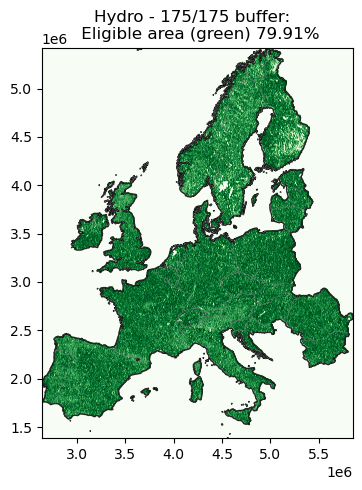

In [14]:
# Create subplots - one for each file
n_files = len(tiff_paths)
columns = 3
rows = math.ceil(n_files/columns)

fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 5 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each file on the corresponding subplot
for ax, tiff_path in tqdm(zip(axes, tiff_paths)):
    print(f'Plotting {tiff_path}')
    plot_eligible_area(ax, tiff_path, europe, f'{name_dict.get(tiff_path)}: ')

# Turn off unused subplots
for ax in axes[n_files:]:
    ax.set_visible(False)
    
output_name = 'hydro_buffered_175'
extensions = ['.pdf','.png']
for extension in extensions:
    plt.tight_layout()
    plt.savefig(f'{output_name}{extension}',bbox_inches='tight')
plt.show()
